# Машинное обучение

Собрав и проанализировав данные по различным количественным и качественным признакам: количество комнат в квартире, ветка метро, общая площадь квартиры и другим, - мы попробуем предсказать цены квартир на 1-7 комнатные квартиры в Москве. Для этого обучим несколько моделей: линейную регрессию, бэггинг и случайный лес, - чтобы сравнить качество моделей и выявить лучшую. В качестве метрики качества была выбрана MAE, так как при визуализации данных наблюдали большое количество выбросов. А метрика MAE менее чувствительна к выбросам.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

In [2]:
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
df = pd.read_csv('our_df.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
df

,Number of Rooms,Square,Current Floor,Total Floors,Price,Requisites Checked,Auction,Коричневая,Голубая,Красная,...,Metro_Шоссе Энтузиастов,Metro_Щукинская,Metro_Щёлковская,Metro_Электрозаводская,Metro_Юго-Восточная,Metro_Юго-Западная,Metro_Южная,Metro_Ясенево,Metro_р-н Северный,Metro_р-н Южное Бутово
0,4,138.0,4,59,74000000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,37.1,3,9,13900000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,132.0,5,59,75000000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,38.0,6,8,13400000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,84.0,5,31,35950000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,1,34.1,8,9,9000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
974,3,64.0,14,14,14300000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
975,1,31.0,3,9,8550000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
976,1,33.0,4,5,10500000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df[" Price"].max() - df[" Price"].min()

347200000

Размах цены: 347200000, - что очень много. Будем учитывать данный факт при анализе получившихся значений метрики MAE.

Разбиваем выборку на две части: обучающую и тестовую, дабы иметь возможность оценить и сравнить получившиеся модели на новых данных.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ' Price'), df[' Price'], test_size=0.2, random_state = 29)

Стандартизируем числовые признаки для повышения интерпретуемости модели и возможности оценить важность признаков для предсказания целевой переменной.

In [6]:
numeric_features = [' Number of Rooms', ' Square', ' Current Floor', ' Total Floors']

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])
X_train[numeric_features] = X_train_scaled
X_test[numeric_features] = X_test_scaled

Для начала сделаем наивный прогноз, в качестве значения которого выступает средняя цена квартир по Москве. Будем использовать его для некоторой численной оценки улучшения качества наших моделей.

In [8]:
from sklearn.metrics import mean_absolute_error

y_const = pd.Series(np.full((1, len(y_test)), df[" Price"].mean())[0])
MAE_test = mean_absolute_error(y_test, y_const)

print(f"MAE test = {MAE_test:.3f}")

MAE test = 13688397.316


Теперь попробуем приблизить значения целевой переменной с помощью линейной регрессии.

In [9]:
from sklearn.linear_model import LinearRegression

model_regression = LinearRegression(fit_intercept = False)
model_regression.fit(X_train, y_train)

y_pred_train = model_regression.predict(X_train)
y_pred_test = model_regression.predict(X_test)

In [10]:
MAE_test = mean_absolute_error(y_test, y_pred_test)
MAE_train = mean_absolute_error(y_train, y_pred_train)

print(f" MAE test = {MAE_test:.3f}; MAE train = {MAE_train:.3f}")

 MAE test = 1433495755732171008.000; MAE train = 4632088.835


Качество на тесте сильно хуже, чем на трейне, что говорит о переобучении модели. Поэтому добавим Лассо регуляризацию. Для этого сначала подберем коэффициент регуляризации.

In [11]:
model_regression.coef_[:50]

array([-8.50984312e+06,  2.34797758e+07,  1.43142853e+05,  3.22645770e+05,
        8.37836832e+05, -5.98556775e+06,  2.67599704e+19, -1.85332253e+19,
       -3.49970112e+19,  3.63453370e+19,  5.34699760e+18,  1.01761745e+18,
       -7.91176711e+18,  3.73226040e+19, -1.61531404e+19,  1.26034851e+19,
        2.60239008e+19,  5.20237364e+19,  3.17859152e+19, -8.51455948e+17,
        3.27022213e+19, -6.33465049e+19, -3.54938811e+19, -1.01761745e+18,
       -1.01761745e+18, -3.63453370e+19,  1.61531404e+19, -2.60239008e+19,
        1.61531404e+19,  1.31862277e+19, -3.63453370e+19, -1.01761745e+18,
        1.85332253e+19,  8.51455948e+17,  7.91176711e+18, -5.34699760e+18,
        7.91176711e+18,  8.51455948e+17, -3.63453370e+19, -6.31053075e+19,
       -1.01761745e+18,  1.61531404e+19, -1.26034851e+19, -3.73226040e+19,
       -1.01761745e+18, -1.26034851e+19,  1.61531404e+19,  3.49970112e+19,
        1.68478720e+07, -1.26034851e+19])

Большие веса - еще один симптом переобучения.

In [12]:
from sklearn.linear_model import LassoCV

alphas = [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 2000000]
reg = LassoCV(cv=5, alphas = alphas).fit(X_train, y_train)
list(zip(reg.alphas_, np.mean(reg.mse_path_, axis = 1)))

[(2000000.0, 231664312040229.2),
 (1000000.0, 226501011158103.94),
 (100000.0, 244720294675430.7),
 (10000.0, 273186036576609.6),
 (1000.0, 281784613000832.6),
 (100.0, 282995517527102.4),
 (10.0, 283109708085335.3),
 (1.0, 283120529310842.2),
 (0.1, 283121587989817.9)]

Наилучшее качество дает alpha = 1000000. 

Посмотрим на влияние параметра регуляризации на евклидову норму весов, которая является численной характеристикой величины вектора. Поэтому используя данную величину можно судить о том, насколькобольшие элементы содержит вектор оценок коэффициентов.

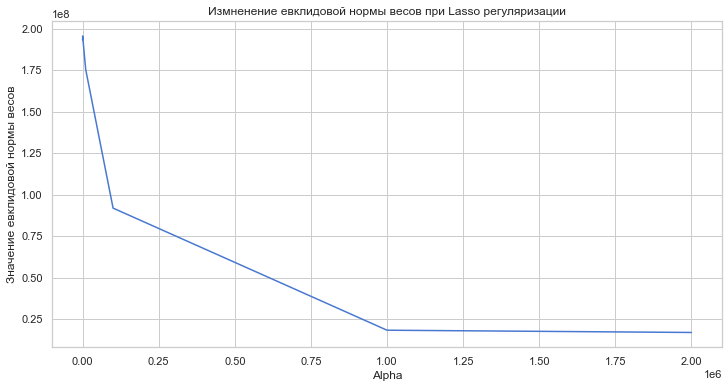

In [14]:
from sklearn.linear_model import Lasso
lasso_norm = np.array([])

for alpha in alphas:
    lasso_model = Lasso(alpha = alpha).fit(X_train, y_train) 
    lasso_norm = np.append(lasso_norm, np.linalg.norm(lasso_model.coef_))

plt.plot(alphas, lasso_norm)
plt.title('Измненение евклидовой нормы весов при Lasso регуляризации')
plt.xlabel('Alpha')
plt.ylabel('Значение евклидовой нормы весов');

Теперь обучим линейную модель с найденным гиперпараметром и посмотрим на качество, дабы проверить эффект регуляризации на переобучение.

In [15]:
lasso_model = Lasso(1000000)
lasso_model.fit(X_train, y_train)

y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred_test)
MAE_train = mean_absolute_error(y_train, y_pred_train)

print(f" MAE test = {MAE_test:.3f}; MAE train = {MAE_train:.3f}")

 MAE test = 6759204.034; MAE train = 6998665.230


Качество значительно улучшилось: на тесте теперь даже выше, чем на трейне. Мы побороли переобучение! Также качество примерно в 2 раза лучше, чем у константной модели.

In [16]:
lasso_model.coef_[:50]

array([ -440715.93899983, 18266847.18247804,       -0.        ,
             -0.        ,        0.        ,       -0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,       -0.        ,
             -0.        ,        0.        ,       -0.        ,
             -0.        ,        0.        ,       -0.        ,
              0.        ,       -0.        ,       -0.        ,
             -0.        ,        0.        ,        0.        ,
             -0.        ,        0.        ,       -0.        ,
              0.        ,       -0.        ,        0.        ,
             -0.        ,       -0.        ,        0.        ,
              0.        ,        0.        ,       -0.        ,
              0.        ,       -0.        ,        0.        ,
              0.        ,       -0.        ,       -0.        ,
             -0.        ,       -0.        ,        0.        ,
             -0.        ,        0.     

Большинство весов занулились, что говорит о низком влиянии данных признаков на целевую переменную.

Теперь попробуем взять другую модель и снова посмотреть на качество. Пусть будет бэггинг, но сначала подберем необходимые гиперпараметры посредством грид-серча.

In [17]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV

In [18]:
np.random.seed(140)

n_estimators = range(1, 50)
max_features = range(1, 20)


choices = []

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features
}

grid_search = GridSearchCV(BaggingRegressor(),
                           param_grid=param_grid, cv = 3, scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

BaggingRegressor(max_features=19, n_estimators=29)


In [19]:
np.random.seed(140)

bag = BaggingRegressor(n_estimators = 9, max_features=19)
bag.fit(X_train, y_train)

y_pred_train = bag.predict(X_train)
y_pred_test = bag.predict(X_test)

MAE_test = mean_absolute_error(y_test, y_pred_test)
MAE_train = mean_absolute_error(y_train, y_pred_train)

print(f" MAE test = {MAE_test:.3f}; MAE train = {MAE_train:.3f}")

 MAE test = 9489764.882; MAE train = 8035520.970


Качество даже ниже, чем у обычной линейной регуляризованной модели. Поэтому отвергаем ее и больше не рассматриваем. Проиграл :(

Теперь посмотрим, как с поставленной задачей справится Random Forest. Аналогично сначала подбираем гиперпараметры.

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
np.random.seed(140)

max_depth_array = range(1, 50)
min_samples_split_array = range(1, 20)
choices = []

param_grid = {
    'max_depth': max_depth_array,
    'min_samples_split': min_samples_split_array
}

grid_search = GridSearchCV(RandomForestRegressor(n_estimators = 100),
                           param_grid=param_grid, cv = 3, scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestRegressor(max_depth=27, min_samples_split=3)


In [22]:
model_rfr = RandomForestRegressor(n_estimators = 100, max_depth = 27, min_samples_split = 3)

model_rfr.fit(X_train, y_train)

y_pred_train = model_rfr.predict(X_train)
y_pred_test = model_rfr.predict(X_test)

rfr_test = mean_absolute_error(y_test.to_numpy(), y_pred_test)
rfr_train = mean_absolute_error(y_train.to_numpy(), y_pred_train)

print(f" MAE test = {rfr_test:.3f}; MAE train = {rfr_train:.3f}")

 MAE test = 3983171.389; MAE train = 1830776.767


Качество значительно улучшилось по сравнению с другими предложенными моделями. Наш победитель --> Random Forest. На первый взгляд кажется, что даже лучшая метрика имеет довольно высокое значение, однако мы помним про большой размах целевой переменной (347200000) и наличие выбросов, которые мы тоже хотели бы научиться пресказывать (из-за чего не исключили их из рассмотрения). Поэтому полученная результирующая ошибка кажется весьма приемлемой ввиду размаха цены в несколько сотен миллионов. 